## Imports

In [57]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import random
import cv2
import zipfile
import sys
from tqdm import tqdm
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm


In [26]:
# drive.mount('/content/drive')
# dataset_path = '/content/drive/MyDrive/Deep-HW2-Data.zip'

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [28]:
!gdown 'https://drive.google.com/uc?id=1gDO7-4SgEfXB_Ls5_LS0ycyMNMPyy1sG'
with zipfile.ZipFile('/content/Deep-HW2-Data.zip', 'r') as zip_ref:
  zip_ref.extractall('/content/')

Downloading...
From (original): https://drive.google.com/uc?id=1gDO7-4SgEfXB_Ls5_LS0ycyMNMPyy1sG
From (redirected): https://drive.google.com/uc?id=1gDO7-4SgEfXB_Ls5_LS0ycyMNMPyy1sG&confirm=t&uuid=c8de2618-c6ef-436d-a4bf-4910765ce706
To: /content/Deep-HW2-Data.zip
100% 53.2M/53.2M [00:00<00:00, 70.5MB/s]


## Utilities

In [29]:
def plot_metric(metric, train_metric, val_metric, epochs=50):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), train_metric, label=f'Training {metric}', alpha=0.5)
    plt.plot(range(1, epochs + 1), val_metric, label=f'Validation {metric}', alpha=0.5)
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.title(f'Training and Validation {metric} Over Epochs')
    plt.legend()
    plt.show()

def load_from_dataset(path, img_size_w, img_size_h):
    data = []
    for f in glob.iglob(path):
        img = cv2.imread(f)
        img = cv2.resize(img,(img_size_w,img_size_h))
        data.append(img)
    return data


## Hyper Parameters

In [30]:
in_channels = 3
num_classes = 2
learning_rate = 3e-4 # karpathy's constant
batch_size = 256
num_epochs = 100

## Dataset

In [35]:
class Data(Dataset):
    def __init__(self, device, img_size_w = 224, img_size_h = 224, mode='train', train_transform=None, val_transform=None):
        self.img_size_w = img_size_w
        self.img_size_h = img_size_h

        self.X_train, self.y_train = None, None
        self.X_test, self.y_test = None, None

        self.mode = mode

        benign_path = "/content/data/benign/*.jpg"
        malignant_path = "/content/data/malignant/*.jpg"

        benign = load_from_dataset (benign_path , img_size_w , img_size_h)
        malignant = load_from_dataset (malignant_path , img_size_w , img_size_h)

        benign = np.array(benign , dtype=np.float32)
        malignant = np.array(malignant , dtype=np.float32)
        print (f'dataset shape is : {benign.shape}')

        benign_labels = np.zeros(benign.shape[0], dtype=np.float32)
        malignant_labels = np.full(malignant.shape[0], 1.0)

        self.images = np.concatenate((benign, malignant), axis=0)
        self.labels = np.concatenate((benign_labels, malignant_labels))

        self.train_transform = train_transform if train_transform else transforms.Compose([
            transforms.ToPILImage(),
            #transforms.Resize((img_size_h, img_size_w)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        self.val_transform = val_transform if val_transform else transforms.Compose([
            transforms.ToPILImage(),
            #transforms.Resize((img_size_h, img_size_w)),
            transforms.ToTensor(),
            #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def train_val_split(self):
        self.X_train, self.X_test, self.y_train, self.y_test = \
        train_test_split(self.images, self.labels, test_size=0.20, random_state=42)

    def __len__(self):
        if self.mode == 'train':
          return self.X_train.shape[0]
        elif self.mode == 'val':
          return self.X_test.shape[0]

    def __getitem__(self, idx):
        if self.mode == 'train':
            image, label = self.X_train[idx], self.y_train[idx]
            image = self.train_transform(image)
        elif self.mode == 'val':
            image, label = self.X_test[idx], self.y_test[idx]
            image = self.val_transform(image)

        label = torch.tensor(label, dtype=torch.float32).to(device)
        return {'image': image, 'label': label}

    def normalize(self):
        self.images = self.images/255.0

    def analyze_class_distribution(self):
        benign_count = np.sum(self.labels == 0)
        malignant_count = np.sum(self.labels == 1)

        print(f"Class Distribution:")
        print(f"  Benign:    {benign_count}")
        print(f"  Malignant: {malignant_count}")

        plt.bar(['Benign', 'Malignant'], [benign_count, malignant_count], color=['blue', 'red'])
        plt.title('Class Distribution')
        plt.ylabel('Count')
        plt.show()

    def balance_with_oversampling(self):
        ros = RandomOverSampler(random_state=42)
        self.images, self.labels = ros.fit_resample(self.images.reshape(len(self.images), -1), self.labels)
        self.images = self.images.reshape(-1, self.img_size_h, self.img_size_w, 3)  # Adjust to original dimensions

    def augment_minority_class(self):
        malignant_indices = np.where(self.labels == 1)[0]
        additional_samples = []
        additional_labels = []
        for idx in malignant_indices:
            image = self.images[idx]
            augmented_image = self.train_transform(image)  # Apply transformations
            additional_samples.append(augmented_image.numpy())
            additional_labels.append(1)

        self.images = np.concatenate((self.images, np.array(additional_samples)))
        self.labels = np.concatenate((self.labels, np.array(additional_labels)))

    def balance_with_undersampling(self):
        rus = RandomUnderSampler(random_state=42)
        self.images, self.labels = rus.fit_resample(self.images.reshape(len(self.images), -1), self.labels)
        self.images = self.images.reshape(-1, self.img_size_h, self.img_size_w, 3)  # Adjust to original dimensions

    def balance_with_smote(self):
        smote = SMOTETomek(random_state=42)
        self.images, self.labels = smote.fit_resample(self.images.reshape(len(self.images), -1), self.labels)
        self.images = self.images.reshape(-1, self.img_size_h, self.img_size_w, 3)  # Adjust to original dimensions

In [36]:
dataset = Data(device, img_size_w=28, img_size_h=28, mode='train',
               train_transform=custom_train_transform,
               val_transform=custom_val_transform)

dataset shape is : (1800, 28, 28, 3)


Class Distribution:
  Benign:    1800
  Malignant: 1497


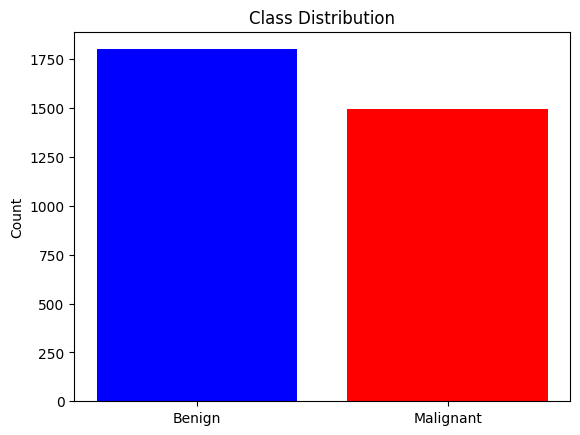

In [37]:
dataset.analyze_class_distribution()

Class Distribution:
  Benign:    1497
  Malignant: 1497


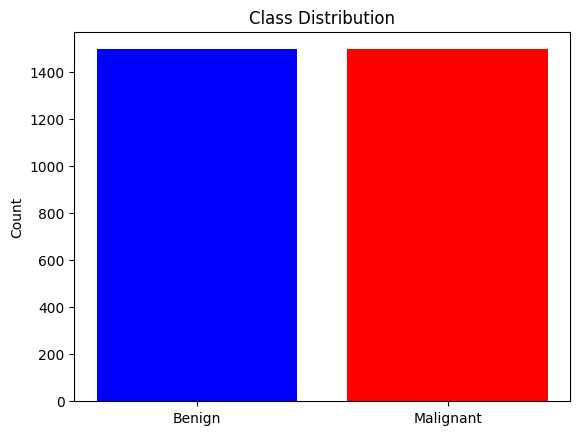

In [39]:
dataset.balance_with_undersampling()

# dataset.balance_with_oversampling()
# dataset.augment_minority_class()
# dataset.balance_with_undersampling()
# dataset.balance_with_smote()

dataset.analyze_class_distribution()

## Model1

In [40]:
class ToTensorAndMove:
    def __init__(self, device):
        self.to_tensor = transforms.ToTensor()
        self.device = device
    def __call__(self, img):
        tensor = self.to_tensor(img)
        return tensor.to(self.device)

In [41]:
custom_train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(28, scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    ToTensorAndMove(device),
])

custom_val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    ToTensorAndMove(device),
])

In [42]:
class SkinCancerCNN(nn.Module):
    def __init__(self):
        super(SkinCancerCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1, stride=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1)
        self.pool3 = nn.MaxPool2d(kernel_size=1, stride=2)

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(2 * 2 * 128, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = F.relu(self.conv3(x))
        x = self.pool3(x)

        x = F.relu(self.conv4(x))
        x = self.pool4(x)

        x = self.flatten(x)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [43]:
model = SkinCancerCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [44]:
def train_model(model, optimizer, criterion, train_loader, val_loader, dataset, num_epochs=10, device='cuda'):
    model.to(device)
    train_accuracies = []
    train_losses = []
    val_accuracies = []
    val_losses = []
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10, verbose=True)

    for epoch in range(num_epochs):
        print(f"Epoch [{epoch + 1}/{num_epochs}]")
        dataset.mode = 'train'
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        with tqdm(total=len(train_loader), desc="Training", unit="batch") as pbar:
            for batch in train_loader:
                images, labels = batch['image'].to(device), batch['label'].to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels.long())

                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                pbar.set_postfix(loss=loss.item(), accuracy=100. * correct / total)
                pbar.update(1)

        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = 100. * correct / total
        # print(f"Training Loss: {avg_train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")
        train_accuracies.append(train_accuracy)
        train_losses.append(avg_train_loss)

        model.eval()
        dataset.mode = 'val'
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            with tqdm(total=len(val_loader), desc="Validation", unit="batch") as pbar:
                for batch in val_loader:
                    images, labels = batch['image'].to(device), batch['label'].to(device)

                    outputs = model(images)
                    loss = criterion(outputs, labels.long())

                    val_loss += loss.item()
                    _, predicted = outputs.max(1)
                    total += labels.size(0)
                    correct += predicted.eq(labels).sum().item()

                    pbar.set_postfix(loss=loss.item(), accuracy=100. * correct / total)
                    pbar.update(1)

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100. * correct / total
        # print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")
        print("-" * 30)
        val_accuracies.append(val_accuracy)
        val_losses.append(avg_val_loss)
        mean_loss = sum(train_losses) / len(train_losses)
        mean_loss = round(mean_loss, 2)
        scheduler.step(mean_loss)

    return train_accuracies, train_losses, val_accuracies, val_losses


In [45]:
dataset.normalize()
dataset.train_val_split()

train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [46]:
train_accuracies, train_losses, val_accuracy, val_losses = train_model(model, optimizer, criterion,
                                                                       train_dataloader, test_dataloader, dataset, num_epochs=num_epochs, device=device)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.60batch/s, accuracy=50.1, loss=0.692]


------------------------------
Epoch [2/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.94batch/s, accuracy=51.9, loss=0.692]


------------------------------
Epoch [3/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.40batch/s, accuracy=52.6, loss=0.693]


------------------------------
Epoch [4/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.39batch/s, accuracy=58.1, loss=0.689]


------------------------------
Epoch [5/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.57batch/s, accuracy=68.9, loss=0.683]


------------------------------
Epoch [6/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.00batch/s, accuracy=67.1, loss=0.663]


------------------------------
Epoch [7/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.23batch/s, accuracy=71, loss=0.595]


------------------------------
Epoch [8/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.40batch/s, accuracy=77.5, loss=0.498]


------------------------------
Epoch [9/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  6.02batch/s, accuracy=78.5, loss=0.473]


------------------------------
Epoch [10/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.21batch/s, accuracy=79.3, loss=0.417]


------------------------------
Epoch [11/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.28batch/s, accuracy=81, loss=0.415]


------------------------------
Epoch [12/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.17batch/s, accuracy=80.8, loss=0.417]


------------------------------
Epoch [13/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.94batch/s, accuracy=82, loss=0.415]


------------------------------
Epoch [14/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.48batch/s, accuracy=81.5, loss=0.421]


------------------------------
Epoch [15/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.37batch/s, accuracy=80.5, loss=0.416]


------------------------------
Epoch [16/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.61batch/s, accuracy=81.8, loss=0.447]


------------------------------
Epoch [17/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  6.64batch/s, accuracy=81.3, loss=0.407]


------------------------------
Epoch [18/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.11batch/s, accuracy=80.8, loss=0.46]


------------------------------
Epoch [19/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.33batch/s, accuracy=80.1, loss=0.413]


------------------------------
Epoch [20/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.05batch/s, accuracy=78.8, loss=0.481]


------------------------------
Epoch [21/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  6.95batch/s, accuracy=81, loss=0.45]


------------------------------
Epoch [22/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.02batch/s, accuracy=81.8, loss=0.427]


------------------------------
Epoch [23/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.41batch/s, accuracy=82.1, loss=0.428]


------------------------------
Epoch [24/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.32batch/s, accuracy=82.3, loss=0.416]


------------------------------
Epoch [25/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  6.33batch/s, accuracy=82.3, loss=0.368]


------------------------------
Epoch [26/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.20batch/s, accuracy=78.8, loss=0.406]


------------------------------
Epoch [27/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.33batch/s, accuracy=80.3, loss=0.375]


------------------------------
Epoch [28/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.32batch/s, accuracy=83.6, loss=0.388]


------------------------------
Epoch [29/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.19batch/s, accuracy=81.1, loss=0.372]


------------------------------
Epoch [30/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.31batch/s, accuracy=80.6, loss=0.371]


------------------------------
Epoch [31/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.56batch/s, accuracy=80.6, loss=0.369]


------------------------------
Epoch [32/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.19batch/s, accuracy=81.8, loss=0.396]


------------------------------
Epoch [33/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.08batch/s, accuracy=82.3, loss=0.391]


------------------------------
Epoch [34/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.45batch/s, accuracy=81.6, loss=0.39]


------------------------------
Epoch [35/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.13batch/s, accuracy=82, loss=0.375]


------------------------------
Epoch [36/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.84batch/s, accuracy=82.3, loss=0.371]


------------------------------
Epoch [37/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.20batch/s, accuracy=78.8, loss=0.381]


------------------------------
Epoch [38/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.39batch/s, accuracy=81.6, loss=0.336]


------------------------------
Epoch [39/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.15batch/s, accuracy=79.8, loss=0.331]


------------------------------
Epoch [40/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.35batch/s, accuracy=82.6, loss=0.362]


------------------------------
Epoch [41/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.83batch/s, accuracy=81.3, loss=0.343]


------------------------------
Epoch [42/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.66batch/s, accuracy=81.8, loss=0.344]


------------------------------
Epoch [43/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.35batch/s, accuracy=80.8, loss=0.33]


------------------------------
Epoch [44/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.51batch/s, accuracy=81.1, loss=0.348]


------------------------------
Epoch [45/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.34batch/s, accuracy=83.3, loss=0.33]


------------------------------
Epoch [46/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  6.32batch/s, accuracy=83.8, loss=0.344]


------------------------------
Epoch [47/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.32batch/s, accuracy=82.6, loss=0.357]


------------------------------
Epoch [48/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.19batch/s, accuracy=80, loss=0.352]


------------------------------
Epoch [49/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.11batch/s, accuracy=82.5, loss=0.351]


------------------------------
Epoch [50/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  6.30batch/s, accuracy=82.8, loss=0.342]


------------------------------
Epoch [51/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.09batch/s, accuracy=82.3, loss=0.344]


------------------------------
Epoch [52/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.03batch/s, accuracy=82.6, loss=0.336]


------------------------------
Epoch [53/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.15batch/s, accuracy=81.5, loss=0.334]


------------------------------
Epoch [54/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.26batch/s, accuracy=81.3, loss=0.337]


------------------------------
Epoch [55/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.47batch/s, accuracy=82.8, loss=0.353]


------------------------------
Epoch [56/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.06batch/s, accuracy=82.8, loss=0.334]


------------------------------
Epoch [57/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.91batch/s, accuracy=81.3, loss=0.325]


------------------------------
Epoch [58/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.26batch/s, accuracy=82.8, loss=0.322]


------------------------------
Epoch [59/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.43batch/s, accuracy=81.8, loss=0.341]


------------------------------
Epoch [60/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.87batch/s, accuracy=83.3, loss=0.345]


------------------------------
Epoch [61/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.11batch/s, accuracy=83, loss=0.348]


------------------------------
Epoch [62/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.98batch/s, accuracy=82.1, loss=0.333]


------------------------------
Epoch [63/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.74batch/s, accuracy=82.5, loss=0.311]


------------------------------
Epoch [64/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.11batch/s, accuracy=82, loss=0.334]


------------------------------
Epoch [65/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.08batch/s, accuracy=81.5, loss=0.325]


------------------------------
Epoch [66/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.41batch/s, accuracy=81.5, loss=0.335]


------------------------------
Epoch [67/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.23batch/s, accuracy=82.6, loss=0.315]


------------------------------
Epoch [68/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.73batch/s, accuracy=82.1, loss=0.337]


------------------------------
Epoch [69/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.23batch/s, accuracy=83.6, loss=0.327]


------------------------------
Epoch [70/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.84batch/s, accuracy=82.1, loss=0.329]


------------------------------
Epoch [71/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.73batch/s, accuracy=82.1, loss=0.318]


------------------------------
Epoch [72/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.38batch/s, accuracy=83.6, loss=0.332]


------------------------------
Epoch [73/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.15batch/s, accuracy=83.3, loss=0.331]


------------------------------
Epoch [74/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.16batch/s, accuracy=81.3, loss=0.31]


------------------------------
Epoch [75/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.89batch/s, accuracy=80.8, loss=0.34]


------------------------------
Epoch [76/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.93batch/s, accuracy=80, loss=0.341]


------------------------------
Epoch [77/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.29batch/s, accuracy=82.1, loss=0.325]


------------------------------
Epoch [78/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.37batch/s, accuracy=83.5, loss=0.334]


------------------------------
Epoch [79/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  3.41batch/s, accuracy=81.1, loss=0.332]


------------------------------
Epoch [80/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.27batch/s, accuracy=81.1, loss=0.322]


------------------------------
Epoch [81/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.17batch/s, accuracy=82.3, loss=0.317]


------------------------------
Epoch [82/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.81batch/s, accuracy=82.3, loss=0.338]


------------------------------
Epoch [83/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.96batch/s, accuracy=82.3, loss=0.316]


------------------------------
Epoch [84/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.36batch/s, accuracy=82.6, loss=0.308]


------------------------------
Epoch [85/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.22batch/s, accuracy=81.5, loss=0.314]


------------------------------
Epoch [86/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.02batch/s, accuracy=80.5, loss=0.324]


------------------------------
Epoch [87/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.32batch/s, accuracy=81.8, loss=0.306]


------------------------------
Epoch [88/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.19batch/s, accuracy=82.3, loss=0.308]


------------------------------
Epoch [89/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.37batch/s, accuracy=83, loss=0.318]


------------------------------
Epoch [90/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.30batch/s, accuracy=82, loss=0.323]


------------------------------
Epoch [91/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.12batch/s, accuracy=82.3, loss=0.325]


------------------------------
Epoch [92/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.91batch/s, accuracy=83.3, loss=0.313]


------------------------------
Epoch [93/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.97batch/s, accuracy=83, loss=0.31]


------------------------------
Epoch [94/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.91batch/s, accuracy=83.1, loss=0.318]


------------------------------
Epoch [95/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.26batch/s, accuracy=81.8, loss=0.313]


------------------------------
Epoch [96/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  6.45batch/s, accuracy=82.3, loss=0.297]


------------------------------
Epoch [97/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.45batch/s, accuracy=82.6, loss=0.287]


------------------------------
Epoch [98/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.68batch/s, accuracy=83.1, loss=0.295]


------------------------------
Epoch [99/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.74batch/s, accuracy=82, loss=0.319]


------------------------------
Epoch [100/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.50batch/s, accuracy=81.8, loss=0.315]

------------------------------


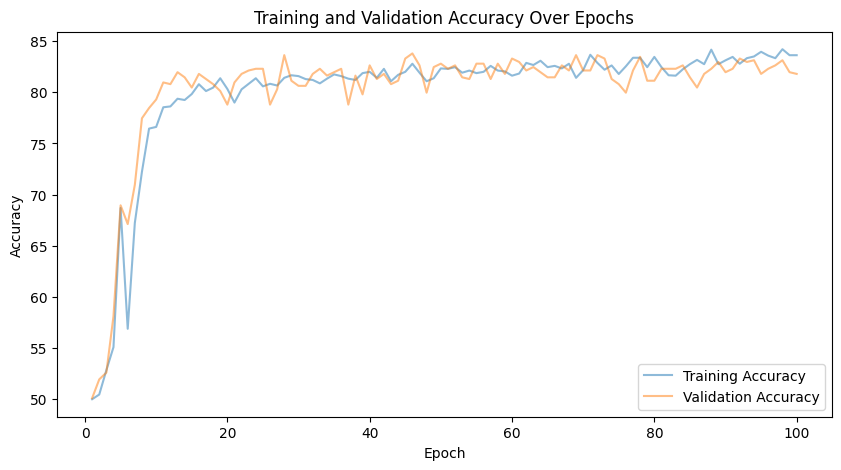

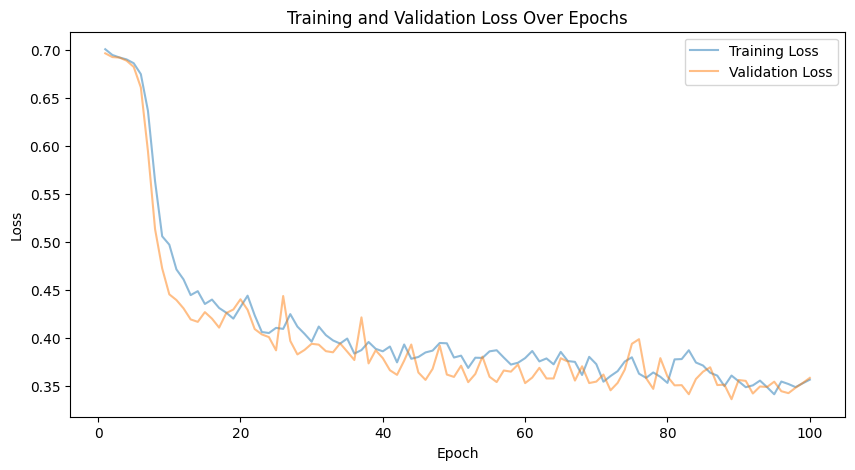

In [47]:
plot_metric('Accuracy', train_accuracies, val_accuracy, epochs=num_epochs)
plot_metric('Loss', train_losses, val_losses, epochs=num_epochs)

## Model2

In [50]:
class conv_block(nn.Module):
  def __init__(self, in_channels, out_channels, **kwargs):
    super(conv_block, self).__init__()
    self.relu = nn.ReLU()
    self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
    self.batchnorm = nn.BatchNorm2d(out_channels)

  def forward(self, x):
    return self.relu(self.batchnorm(self.conv(x)))

In [51]:
class ImprovedSkinCancerCNN(nn.Module):
    def __init__(self):
        super(ImprovedSkinCancerCNN, self).__init__()

        self.conv1 = conv_block(in_channels=3, out_channels=64, kernel_size=3, padding=1, stride=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(p=0.15)

        self.conv2 = conv_block(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(p=0.15)

        self.conv3 = conv_block(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1)
        self.pool3 = nn.MaxPool2d(kernel_size=1, stride=2)
        self.dropout3 = nn.Dropout(p=0.15)

        self.conv4 = conv_block(in_channels=256, out_channels=512, kernel_size=3, padding=1, stride=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout4 = nn.Dropout(p=0.15)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(2 * 2 * 512, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = self.pool2(x)
        x = self.dropout2(x)

        x = self.conv3(x)
        x = self.pool3(x)
        x = self.dropout3(x)

        x = self.conv4(x)
        x = self.pool4(x)
        x = self.dropout4(x)

        x = self.flatten(x)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [52]:
improvedModel = ImprovedSkinCancerCNN().to(device)
optimizer = optim.Adam(improvedModel.parameters(), lr=learning_rate)
train_accuracies, train_losses, val_accuracy, val_losses = train_model(improvedModel, optimizer, criterion,
                                                                       train_dataloader, test_dataloader, dataset,
                                                                       num_epochs=num_epochs, device=device)

Epoch [1/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.69batch/s, accuracy=61.6, loss=0.681]


------------------------------
Epoch [2/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.97batch/s, accuracy=64.3, loss=0.618]


------------------------------
Epoch [3/100]


Validation: 100%|██████████| 3/3 [00:01<00:00,  2.14batch/s, accuracy=77.1, loss=0.445]


------------------------------
Epoch [4/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  3.79batch/s, accuracy=70.3, loss=0.714]


------------------------------
Epoch [5/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.35batch/s, accuracy=81, loss=0.336]


------------------------------
Epoch [6/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  6.49batch/s, accuracy=83.5, loss=0.321]


------------------------------
Epoch [7/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.05batch/s, accuracy=83.3, loss=0.315]


------------------------------
Epoch [8/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.21batch/s, accuracy=82.5, loss=0.307]


------------------------------
Epoch [9/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  6.13batch/s, accuracy=83.3, loss=0.316]


------------------------------
Epoch [10/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.08batch/s, accuracy=80.6, loss=0.333]


------------------------------
Epoch [11/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.64batch/s, accuracy=84.1, loss=0.289]


------------------------------
Epoch [12/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.70batch/s, accuracy=82.3, loss=0.29]


------------------------------
Epoch [13/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.99batch/s, accuracy=82.1, loss=0.286]


------------------------------
Epoch [14/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.16batch/s, accuracy=84.1, loss=0.246]


------------------------------
Epoch [15/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.08batch/s, accuracy=83.3, loss=0.247]


------------------------------
Epoch [16/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.22batch/s, accuracy=83.6, loss=0.268]


------------------------------
Epoch [17/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.20batch/s, accuracy=84, loss=0.264]


------------------------------
Epoch [18/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.95batch/s, accuracy=86, loss=0.244]


------------------------------
Epoch [19/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.68batch/s, accuracy=85, loss=0.236]


------------------------------
Epoch [20/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.78batch/s, accuracy=82.5, loss=0.284]


------------------------------
Epoch [21/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.72batch/s, accuracy=83.6, loss=0.286]


------------------------------
Epoch [22/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.85batch/s, accuracy=85.3, loss=0.256]


------------------------------
Epoch [23/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.07batch/s, accuracy=84, loss=0.286]


------------------------------
Epoch [24/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  6.38batch/s, accuracy=83.1, loss=0.251]


------------------------------
Epoch [25/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.86batch/s, accuracy=84.6, loss=0.277]


------------------------------
Epoch [26/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.74batch/s, accuracy=85.1, loss=0.302]


------------------------------
Epoch [27/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.64batch/s, accuracy=85.1, loss=0.239]


------------------------------
Epoch [28/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.74batch/s, accuracy=84.8, loss=0.253]


------------------------------
Epoch [29/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.87batch/s, accuracy=84.6, loss=0.244]


------------------------------
Epoch [30/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.83batch/s, accuracy=84, loss=0.254]


------------------------------
Epoch [31/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.83batch/s, accuracy=84, loss=0.254]


------------------------------
Epoch [32/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  6.04batch/s, accuracy=85.1, loss=0.241]


------------------------------
Epoch [33/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.72batch/s, accuracy=86, loss=0.247]


------------------------------
Epoch [34/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.83batch/s, accuracy=82.8, loss=0.292]


------------------------------
Epoch [35/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.77batch/s, accuracy=85.1, loss=0.282]


------------------------------
Epoch [36/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.70batch/s, accuracy=85.5, loss=0.243]


------------------------------
Epoch [37/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.00batch/s, accuracy=84.5, loss=0.238]


------------------------------
Epoch [38/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.13batch/s, accuracy=86.3, loss=0.239]


------------------------------
Epoch [39/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.06batch/s, accuracy=85.3, loss=0.241]


------------------------------
Epoch [40/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.41batch/s, accuracy=85.6, loss=0.277]


------------------------------
Epoch [41/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.09batch/s, accuracy=84.3, loss=0.212]


------------------------------
Epoch [42/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.93batch/s, accuracy=83.5, loss=0.274]


------------------------------
Epoch [43/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.88batch/s, accuracy=84, loss=0.302]


------------------------------
Epoch [44/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.47batch/s, accuracy=84.1, loss=0.239]


------------------------------
Epoch [45/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.83batch/s, accuracy=85, loss=0.277]


------------------------------
Epoch [46/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.07batch/s, accuracy=85.6, loss=0.235]


------------------------------
Epoch [47/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.10batch/s, accuracy=86, loss=0.254]


------------------------------
Epoch [48/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.83batch/s, accuracy=84.3, loss=0.261]


------------------------------
Epoch [49/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.88batch/s, accuracy=85.8, loss=0.291]


------------------------------
Epoch [50/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.86batch/s, accuracy=84.5, loss=0.304]


------------------------------
Epoch [51/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.84batch/s, accuracy=86.1, loss=0.243]


------------------------------
Epoch [52/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  6.55batch/s, accuracy=86, loss=0.252]


------------------------------
Epoch [53/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.85batch/s, accuracy=84, loss=0.272]


------------------------------
Epoch [54/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.98batch/s, accuracy=84.1, loss=0.274]


------------------------------
Epoch [55/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.97batch/s, accuracy=86.1, loss=0.248]


------------------------------
Epoch [56/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.74batch/s, accuracy=87.1, loss=0.29]


------------------------------
Epoch [57/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.49batch/s, accuracy=84.1, loss=0.268]


------------------------------
Epoch [58/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.59batch/s, accuracy=83.6, loss=0.27]


------------------------------
Epoch [59/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.46batch/s, accuracy=84.8, loss=0.259]


------------------------------
Epoch [60/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.14batch/s, accuracy=83.8, loss=0.286]


------------------------------
Epoch [61/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.54batch/s, accuracy=85, loss=0.281]


------------------------------
Epoch [62/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.76batch/s, accuracy=84.8, loss=0.273]


------------------------------
Epoch [63/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.00batch/s, accuracy=85, loss=0.248]


------------------------------
Epoch [64/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.94batch/s, accuracy=85.3, loss=0.26]


------------------------------
Epoch [65/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.73batch/s, accuracy=84.5, loss=0.264]


------------------------------
Epoch [66/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.86batch/s, accuracy=82.8, loss=0.293]


------------------------------
Epoch [67/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.97batch/s, accuracy=85.3, loss=0.316]


------------------------------
Epoch [68/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.68batch/s, accuracy=76.6, loss=0.593]


------------------------------
Epoch [69/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.59batch/s, accuracy=84.3, loss=0.381]


------------------------------
Epoch [70/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.06batch/s, accuracy=75.6, loss=0.511]


------------------------------
Epoch [71/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  6.57batch/s, accuracy=83.5, loss=0.407]


------------------------------
Epoch [72/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.83batch/s, accuracy=83.8, loss=0.298]


------------------------------
Epoch [73/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.97batch/s, accuracy=84.8, loss=0.327]


------------------------------
Epoch [74/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.07batch/s, accuracy=83, loss=0.365]


------------------------------
Epoch [75/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.69batch/s, accuracy=83.5, loss=0.332]


------------------------------
Epoch [76/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.99batch/s, accuracy=85.1, loss=0.294]


------------------------------
Epoch [77/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.02batch/s, accuracy=85.1, loss=0.221]


------------------------------
Epoch [78/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.11batch/s, accuracy=85.8, loss=0.278]


------------------------------
Epoch [79/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  6.02batch/s, accuracy=83.8, loss=0.242]


------------------------------
Epoch [80/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.77batch/s, accuracy=86.1, loss=0.271]


------------------------------
Epoch [81/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.01batch/s, accuracy=85.5, loss=0.292]


------------------------------
Epoch [82/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.99batch/s, accuracy=85.3, loss=0.269]


------------------------------
Epoch [83/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.41batch/s, accuracy=85.8, loss=0.26]


------------------------------
Epoch [84/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.97batch/s, accuracy=86.1, loss=0.305]


------------------------------
Epoch [85/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.03batch/s, accuracy=84.1, loss=0.243]


------------------------------
Epoch [86/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.08batch/s, accuracy=84.6, loss=0.247]


------------------------------
Epoch [87/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.19batch/s, accuracy=86.1, loss=0.251]


------------------------------
Epoch [88/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.15batch/s, accuracy=86.6, loss=0.29]


------------------------------
Epoch [89/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.23batch/s, accuracy=84.8, loss=0.297]


------------------------------
Epoch [90/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.12batch/s, accuracy=85.8, loss=0.279]


------------------------------
Epoch [91/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.59batch/s, accuracy=83.8, loss=0.403]


------------------------------
Epoch [92/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.04batch/s, accuracy=83.3, loss=0.272]


------------------------------
Epoch [93/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.05batch/s, accuracy=84.8, loss=0.235]


------------------------------
Epoch [94/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.87batch/s, accuracy=86, loss=0.301]


------------------------------
Epoch [95/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  6.17batch/s, accuracy=83.3, loss=0.355]


------------------------------
Epoch [96/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.00batch/s, accuracy=84.1, loss=0.28]


------------------------------
Epoch [97/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  7.43batch/s, accuracy=85.3, loss=0.298]


------------------------------
Epoch [98/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.11batch/s, accuracy=86.5, loss=0.253]


------------------------------
Epoch [99/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.01batch/s, accuracy=85.6, loss=0.292]


------------------------------
Epoch [100/100]


Validation: 100%|██████████| 3/3 [00:00<00:00,  8.10batch/s, accuracy=85.3, loss=0.282]

------------------------------


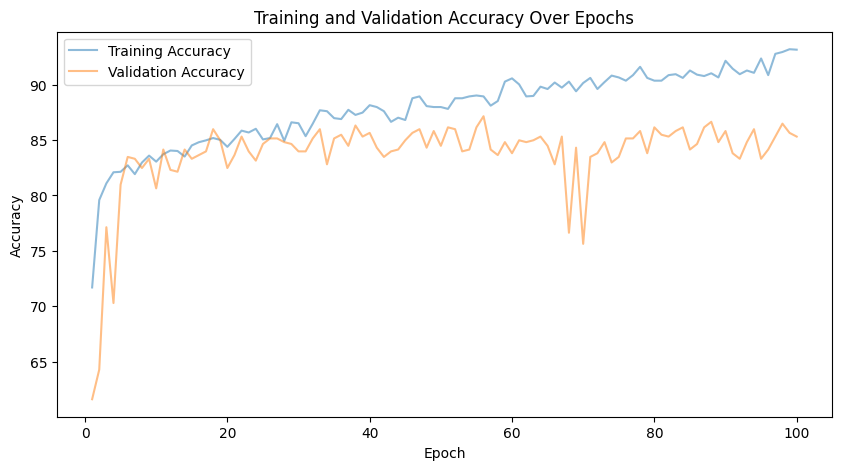

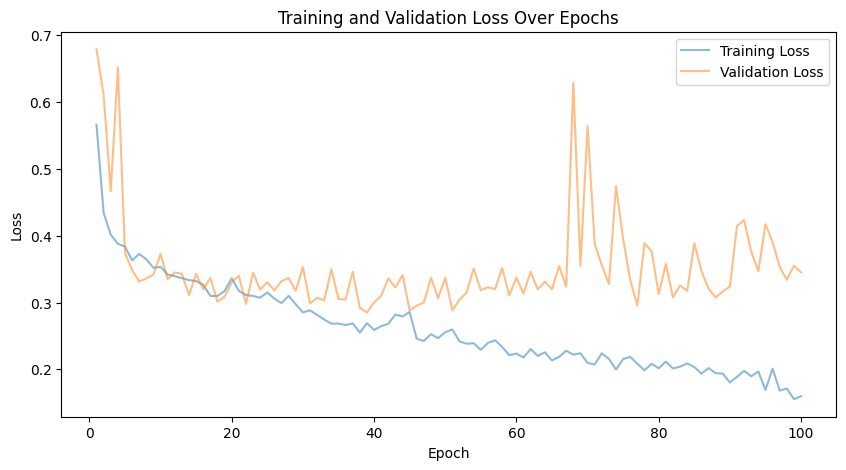

In [53]:
plot_metric('Accuracy', train_accuracies, val_accuracy, epochs=num_epochs)
plot_metric('Loss', train_losses, val_losses, epochs=num_epochs)

## GoogleNet

In [54]:
class GoogLeNet(nn.Module):
  def __init__(self, aux_logits=True, num_classes=4):
    super(GoogLeNet, self).__init__()
    assert aux_logits == True or aux_logits == False
    self.aux_logits = aux_logits

    self.conv1 = conv_block(
        in_channels=3,
        out_channels=64,
        kernel_size=7,
        stride=2,
        padding=3,
    )

    self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    self.conv2 = conv_block(64, 192, kernel_size=3, stride=1, padding=1)
    self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    # In this order: in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool
    self.inception3a = Inception_block(192, 64, 96, 128, 16, 32, 32)
    self.inception3b = Inception_block(256, 128, 128, 192, 32, 96, 64)
    self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    self.inception4a = Inception_block(480, 192, 96, 208, 16, 48, 64)
    self.inception4b = Inception_block(512, 160, 112, 224, 24, 64, 64)
    self.inception4c = Inception_block(512, 128, 128, 256, 24, 64, 64)
    self.inception4d = Inception_block(512, 112, 144, 288, 32, 64, 64)
    self.inception4e = Inception_block(528, 256, 160, 320, 32, 128, 128)
    self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    self.inception5a = Inception_block(832, 256, 160, 320, 32, 128, 128)
    self.inception5b = Inception_block(832, 384, 192, 384, 48, 128, 128)

    self.avgpool = nn.AvgPool2d(kernel_size=7, stride=1)
    self.dropout = nn.Dropout(p=0.4)
    self.fc1 = nn.Linear(1024, num_classes)

    if self.aux_logits:
      self.aux1 = InceptionAux(512, num_classes)
      self.aux2 = InceptionAux(528, num_classes)
    else:
      self.aux1 = self.aux2 = None

  def forward(self, x ):
    x = self.conv1(x)       #
    x = self.maxpool1(x)    #
    x = self.conv2(x)       #
    x = self.maxpool2(x)    #

    x = self.inception3a(x) # 192, 64
    x = self.inception3b(x) # 256, 128
    x = self.maxpool3(x)    #

    x = self.inception4a(x) #

    # Auxiliary Softmax classifier 1
    if self.aux_logits and self.training:
      aux1 = self.aux1(x)

    x = self.inception4b(x) # 512, 160
    x = self.inception4c(x) # 512, 128
    x = self.inception4d(x) # 512, 112

    # Auxiliary Softmax classifier 2
    if self.aux_logits and self.training:
      aux2 = self.aux2(x)

    x = self.inception4e(x)
    x = self.maxpool4(x)
    x = self.inception5a(x)
    x = self.inception5b(x)
    x = self.avgpool(x)
    x = x.reshape(x.shape[0], -1)
    x = self.dropout(x)
    x = self.fc1(x)

    if self.aux_logits and self.training:
      return aux1, aux2, x
    else:
      return x


class Inception_block(nn.Module):
  def __init__(self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool):
    super(Inception_block, self).__init__()
    self.branch1 = conv_block(in_channels, out_1x1, kernel_size=1)

    self.branch2 = nn.Sequential(
      conv_block(in_channels, red_3x3, kernel_size=1),
      conv_block(red_3x3, out_3x3, kernel_size=(3, 3), padding=1),
    )

    self.branch3 = nn.Sequential(
      conv_block(in_channels, red_5x5, kernel_size=1),
      conv_block(red_5x5, out_5x5, kernel_size=5, padding=2),
    )

    self.branch4 = nn.Sequential(
      nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
      conv_block(in_channels, out_1x1pool, kernel_size=1),
    )

  def forward(self, x):
    return torch.cat([self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)], 1)


class InceptionAux(nn.Module):
  def __init__(self, in_channels, num_classes):
    super(InceptionAux, self).__init__()
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(p=0.7)
    self.pool = nn.AvgPool2d(kernel_size=5, stride=3)
    self.conv = conv_block(in_channels, 128, kernel_size=1)
    self.fc1 = nn.Linear(2048, 1024)
    self.fc2 = nn.Linear(1024, num_classes)

  def forward(self, x):
    x = self.pool(x)
    x = self.conv(x)
    x = x.reshape(x.shape[0], -1)
    x = self.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)
    return x


class conv_block(nn.Module):
  def __init__(self, in_channels, out_channels, **kwargs):
    super(conv_block, self).__init__()
    self.relu = nn.ReLU()
    self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
    self.batchnorm = nn.BatchNorm2d(out_channels)

  def forward(self, x):
    return self.relu(self.batchnorm(self.conv(x)))



In [55]:
custom_train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    ToTensorAndMove(device),
])

custom_val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    ToTensorAndMove(device),
])

In [56]:
google_net_dataset = Data(device, mode='train',
                               train_transform=custom_train_transform, val_transform=custom_val_transform)

google_net_dataset.balance_with_undersampling()

google_net_dataset.normalize()
google_net_dataset.train_val_split()

google_net_train_dataloader = DataLoader(google_net_dataset, batch_size=batch_size, shuffle=True)
google_net_test_dataloader = DataLoader(google_net_dataset, batch_size=batch_size, shuffle=False)

dataset shape is : (1800, 224, 224, 3)


In [58]:
def train_model(model, optimizer, criterion, train_loader, val_loader, dataset, num_epochs=10, device='cuda'):
    model.to(device)
    train_accuracies = []
    train_losses = []
    val_accuracies = []
    val_losses = []

    # Learning rate scheduler based on validation loss
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10, verbose=True)

    for epoch in range(num_epochs):
        print(f"Epoch [{epoch + 1}/{num_epochs}]")

        # Training phase
        dataset.mode = 'train'
        model.train()
        total_train_loss = 0.0
        correct_train = 0
        total_train = 0

        with tqdm(total=len(train_loader), desc="Training", unit="batch") as pbar:
            for batch in train_loader:
                images, labels = batch['image'].to(device), batch['label'].to(device)
                # print('images.shape: ', images.shape)
                # Forward pass
                optimizer.zero_grad()
                outputs = model(images)

                # Compute loss
                if isinstance(outputs, tuple):  # GoogLeNet produces multiple outputs
                    loss1 = criterion(outputs[0], labels.long())
                    loss2 = criterion(outputs[1], labels.long())
                    loss3 = criterion(outputs[2], labels.long())
                    loss = loss1 + loss2 + loss3
                else:
                    loss = criterion(outputs, labels.long())

                # Backward pass
                loss.backward()
                optimizer.step()

                total_train_loss += loss.item()

                # Calculate accuracy
                _, predicted = torch.max(outputs[2], 1)
                # _, predicted = outputs[0].max(1)  # Use primary output for accuracy
                total_train += labels.size(0)
                correct_train += predicted.eq(labels).sum().item()

                # Progress bar update
                pbar.set_postfix(loss=loss.item(), accuracy=100. * correct_train / total_train)
                pbar.update(1)

        # Calculate average training loss and accuracy for the epoch
        avg_train_loss = total_train_loss / len(train_loader)
        train_accuracy = 100. * correct_train / total_train
        train_accuracies.append(train_accuracy)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        dataset.mode = 'val'
        total_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            with tqdm(total=len(val_loader), desc="Validation", unit="batch") as pbar:
                for batch in val_loader:
                    images, labels = batch['image'].to(device), batch['label'].to(device)
                    # print(images.shape)

                    # Forward pass
                    outputs = model(images)

                    # # Compute loss
                    # if isinstance(outputs, tuple):
                    #     loss1 = criterion(outputs[0], labels.long())
                    #     loss2 = criterion(outputs[1], labels.long())
                    #     loss3 = criterion(outputs[2], labels.long())
                    #     loss = loss1 + loss2 + loss3
                    # else:
                    loss = criterion(outputs, labels.long())

                    total_val_loss += loss.item()

                    # Calculate accuracy
                    _, predicted = outputs.max(1)
                    # _, predicted = torch.max(outputs[2], 1)  # Use primary output for accuracy
                    total_val += labels.size(0)
                    correct_val += predicted.eq(labels).sum().item()

                    # Progress bar update
                    pbar.set_postfix(loss=loss.item(), accuracy=100. * correct_val / total_val)
                    pbar.update(1)

        # Calculate average validation loss and accuracy for the epoch
        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = 100. * correct_val / total_val
        val_accuracies.append(val_accuracy)
        val_losses.append(avg_val_loss)

        # Print epoch results
        print(f"Training Loss: {avg_train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")
        print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")
        print("-" * 30)

        # Step the learning rate scheduler based on validation loss
        scheduler.step(avg_val_loss)

    return train_accuracies, train_losses, val_accuracies, val_losses


In [59]:
google_net_model = GoogLeNet().to(device)
optimizer = optim.Adam(google_net_model.parameters(), lr=learning_rate)
train_accuracies, train_losses, val_accuracy, val_losses = train_model(google_net_model, optimizer, criterion,
                                                                       google_net_train_dataloader, google_net_test_dataloader,
                                                                       google_net_dataset, num_epochs=num_epochs, device=device)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/100]


Validation: 100%|██████████| 3/3 [00:03<00:00,  1.17s/batch, accuracy=50.1, loss=1.07]


Training Loss: 1.8939, Accuracy: 73.53%
Validation Loss: 1.0793, Accuracy: 50.08%
------------------------------
Epoch [2/100]


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.10batch/s, accuracy=49.9, loss=0.825]


Training Loss: 1.1791, Accuracy: 81.59%
Validation Loss: 0.8062, Accuracy: 49.92%
------------------------------
Epoch [3/100]


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.07batch/s, accuracy=52.3, loss=1.35]


Training Loss: 1.1208, Accuracy: 83.30%
Validation Loss: 1.2088, Accuracy: 52.25%
------------------------------
Epoch [4/100]


Validation: 100%|██████████| 3/3 [00:03<00:00,  1.02s/batch, accuracy=71.3, loss=0.583]


Training Loss: 1.0404, Accuracy: 83.84%
Validation Loss: 0.5309, Accuracy: 71.29%
------------------------------
Epoch [5/100]


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.07batch/s, accuracy=82.5, loss=0.354]


Training Loss: 0.9860, Accuracy: 84.22%
Validation Loss: 0.3610, Accuracy: 82.47%
------------------------------
Epoch [6/100]


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.02batch/s, accuracy=85.6, loss=0.292]


Training Loss: 0.9212, Accuracy: 84.84%
Validation Loss: 0.3423, Accuracy: 85.64%
------------------------------
Epoch [7/100]


Validation: 100%|██████████| 3/3 [00:03<00:00,  1.16s/batch, accuracy=82.6, loss=0.293]


Training Loss: 0.9179, Accuracy: 85.68%
Validation Loss: 0.3332, Accuracy: 82.64%
------------------------------
Epoch [8/100]


Validation: 100%|██████████| 3/3 [00:03<00:00,  1.01s/batch, accuracy=82.1, loss=0.29]


Training Loss: 0.8679, Accuracy: 86.26%
Validation Loss: 0.4016, Accuracy: 82.14%
------------------------------
Epoch [9/100]


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.09batch/s, accuracy=82, loss=0.391]


Training Loss: 0.8065, Accuracy: 87.52%
Validation Loss: 0.4030, Accuracy: 81.97%
------------------------------
Epoch [10/100]


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.07batch/s, accuracy=82.8, loss=0.288]


Training Loss: 0.8174, Accuracy: 86.97%
Validation Loss: 0.3697, Accuracy: 82.80%
------------------------------
Epoch [11/100]


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.07batch/s, accuracy=82.8, loss=0.431]


Training Loss: 0.7987, Accuracy: 88.31%
Validation Loss: 0.4474, Accuracy: 82.80%
------------------------------
Epoch [12/100]


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.00batch/s, accuracy=81.3, loss=0.385]


Training Loss: 0.7875, Accuracy: 88.23%
Validation Loss: 0.4742, Accuracy: 81.30%
------------------------------
Epoch [13/100]


Validation: 100%|██████████| 3/3 [00:03<00:00,  1.16s/batch, accuracy=80.3, loss=0.315]


Training Loss: 0.7654, Accuracy: 87.77%
Validation Loss: 0.3929, Accuracy: 80.30%
------------------------------
Epoch [14/100]


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.08batch/s, accuracy=84.3, loss=0.323]


Training Loss: 0.7520, Accuracy: 88.52%
Validation Loss: 0.3672, Accuracy: 84.31%
------------------------------
Epoch [15/100]


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.08batch/s, accuracy=85.1, loss=0.383]


Training Loss: 0.7239, Accuracy: 89.65%
Validation Loss: 0.3487, Accuracy: 85.14%
------------------------------
Epoch [16/100]


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.05batch/s, accuracy=82.8, loss=0.999]


Training Loss: 0.7897, Accuracy: 88.52%
Validation Loss: 1.1208, Accuracy: 82.80%
------------------------------
Epoch [17/100]


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.08batch/s, accuracy=79.6, loss=0.323]


Training Loss: 0.8154, Accuracy: 86.76%
Validation Loss: 0.4199, Accuracy: 79.63%
------------------------------
Epoch [18/100]


Validation: 100%|██████████| 3/3 [00:03<00:00,  1.12s/batch, accuracy=84.5, loss=0.357]


Training Loss: 0.7624, Accuracy: 89.27%
Validation Loss: 0.3579, Accuracy: 84.47%
------------------------------
Epoch [19/100]


Validation: 100%|██████████| 3/3 [00:03<00:00,  1.08s/batch, accuracy=85.1, loss=0.254]


Training Loss: 0.6745, Accuracy: 88.98%
Validation Loss: 0.3121, Accuracy: 85.14%
------------------------------
Epoch [20/100]


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.08batch/s, accuracy=85.8, loss=0.237]


Training Loss: 0.6339, Accuracy: 90.44%
Validation Loss: 0.3079, Accuracy: 85.81%
------------------------------
Epoch [21/100]


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.07batch/s, accuracy=87.5, loss=0.293]


Training Loss: 0.6101, Accuracy: 90.56%
Validation Loss: 0.2988, Accuracy: 87.48%
------------------------------
Epoch [22/100]


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.07batch/s, accuracy=87.6, loss=0.278]


Training Loss: 0.5906, Accuracy: 91.65%
Validation Loss: 0.3001, Accuracy: 87.65%
------------------------------
Epoch [23/100]


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.09batch/s, accuracy=86.1, loss=0.288]


Training Loss: 0.6105, Accuracy: 91.27%
Validation Loss: 0.3044, Accuracy: 86.14%
------------------------------
Epoch [24/100]


Validation: 100%|██████████| 3/3 [00:03<00:00,  1.06s/batch, accuracy=87.1, loss=0.282]


Training Loss: 0.5820, Accuracy: 91.69%
Validation Loss: 0.2995, Accuracy: 87.15%
------------------------------
Epoch [25/100]


Validation: 100%|██████████| 3/3 [00:03<00:00,  1.14s/batch, accuracy=86, loss=0.27]


Training Loss: 0.5737, Accuracy: 91.86%
Validation Loss: 0.3110, Accuracy: 85.98%
------------------------------
Epoch [26/100]


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.02batch/s, accuracy=87.5, loss=0.248]


Training Loss: 0.5599, Accuracy: 91.40%
Validation Loss: 0.2889, Accuracy: 87.48%
------------------------------
Epoch [27/100]


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.08batch/s, accuracy=86.8, loss=0.3]


Training Loss: 0.5566, Accuracy: 92.48%
Validation Loss: 0.3130, Accuracy: 86.81%
------------------------------
Epoch [28/100]


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.06batch/s, accuracy=87.3, loss=0.32]


Training Loss: 0.5498, Accuracy: 91.98%
Validation Loss: 0.3090, Accuracy: 87.31%
------------------------------
Epoch [29/100]


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.07batch/s, accuracy=86.3, loss=0.319]


Training Loss: 0.5084, Accuracy: 93.07%
Validation Loss: 0.3142, Accuracy: 86.31%
------------------------------
Epoch [30/100]


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.08batch/s, accuracy=85.5, loss=0.34]


Training Loss: 0.5115, Accuracy: 92.86%
Validation Loss: 0.3439, Accuracy: 85.48%
------------------------------
Epoch [31/100]


Validation: 100%|██████████| 3/3 [00:03<00:00,  1.07s/batch, accuracy=86.1, loss=0.321]


Training Loss: 0.5053, Accuracy: 93.36%
Validation Loss: 0.3496, Accuracy: 86.14%
------------------------------
Epoch [32/100]


Validation: 100%|██████████| 3/3 [00:03<00:00,  1.11s/batch, accuracy=86.1, loss=0.328]


Training Loss: 0.5195, Accuracy: 92.23%
Validation Loss: 0.3394, Accuracy: 86.14%
------------------------------
Epoch [33/100]


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.02batch/s, accuracy=86.5, loss=0.299]


Training Loss: 0.5402, Accuracy: 92.28%
Validation Loss: 0.3171, Accuracy: 86.48%
------------------------------
Epoch [34/100]


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.08batch/s, accuracy=87.1, loss=0.333]


Training Loss: 0.5057, Accuracy: 92.99%
Validation Loss: 0.3394, Accuracy: 87.15%
------------------------------
Epoch [35/100]


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.07batch/s, accuracy=86.6, loss=0.357]


Training Loss: 0.5073, Accuracy: 93.28%
Validation Loss: 0.3412, Accuracy: 86.64%
------------------------------
Epoch [36/100]


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.08batch/s, accuracy=87.5, loss=0.372]


Training Loss: 0.4877, Accuracy: 92.65%
Validation Loss: 0.3341, Accuracy: 87.48%
------------------------------
Epoch [37/100]


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.07batch/s, accuracy=87.8, loss=0.347]


Training Loss: 0.4986, Accuracy: 92.69%
Validation Loss: 0.3325, Accuracy: 87.81%
------------------------------
Epoch [38/100]


Validation: 100%|██████████| 3/3 [00:03<00:00,  1.07s/batch, accuracy=87.3, loss=0.377]


Training Loss: 0.4699, Accuracy: 93.99%
Validation Loss: 0.3577, Accuracy: 87.31%
------------------------------
Epoch [39/100]


Validation: 100%|██████████| 3/3 [00:03<00:00,  1.13s/batch, accuracy=87.3, loss=0.326]


Training Loss: 0.4985, Accuracy: 93.24%
Validation Loss: 0.3310, Accuracy: 87.31%
------------------------------
Epoch [40/100]


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.01batch/s, accuracy=87.3, loss=0.357]


Training Loss: 0.4599, Accuracy: 93.90%
Validation Loss: 0.3411, Accuracy: 87.31%
------------------------------
Epoch [41/100]


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.06batch/s, accuracy=87.6, loss=0.335]


Training Loss: 0.4691, Accuracy: 93.74%
Validation Loss: 0.3349, Accuracy: 87.65%
------------------------------
Epoch [42/100]


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.07batch/s, accuracy=85.6, loss=0.37]


Training Loss: 0.4488, Accuracy: 94.11%
Validation Loss: 0.3507, Accuracy: 85.64%
------------------------------
Epoch [43/100]


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.09batch/s, accuracy=87.1, loss=0.361]


Training Loss: 0.4625, Accuracy: 93.53%
Validation Loss: 0.3383, Accuracy: 87.15%
------------------------------
Epoch [44/100]


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.09batch/s, accuracy=86.3, loss=0.393]


Training Loss: 0.4375, Accuracy: 94.24%
Validation Loss: 0.3576, Accuracy: 86.31%
------------------------------
Epoch [45/100]


Validation: 100%|██████████| 3/3 [00:03<00:00,  1.05s/batch, accuracy=86.5, loss=0.382]


Training Loss: 0.4485, Accuracy: 94.41%
Validation Loss: 0.3511, Accuracy: 86.48%
------------------------------
Epoch [46/100]


Validation: 100%|██████████| 3/3 [00:03<00:00,  1.12s/batch, accuracy=86.3, loss=0.359]


Training Loss: 0.4518, Accuracy: 94.20%
Validation Loss: 0.3480, Accuracy: 86.31%
------------------------------
Epoch [47/100]


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.02batch/s, accuracy=86.3, loss=0.402]


Training Loss: 0.4543, Accuracy: 93.65%
Validation Loss: 0.3746, Accuracy: 86.31%
------------------------------
Epoch [48/100]


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.09batch/s, accuracy=86.6, loss=0.363]


Training Loss: 0.4670, Accuracy: 93.90%
Validation Loss: 0.3423, Accuracy: 86.64%
------------------------------
Epoch [49/100]


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.08batch/s, accuracy=87.3, loss=0.393]


Training Loss: 0.4699, Accuracy: 94.57%
Validation Loss: 0.3584, Accuracy: 87.31%
------------------------------
Epoch [50/100]


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.08batch/s, accuracy=86.3, loss=0.4]


Training Loss: 0.4368, Accuracy: 93.99%
Validation Loss: 0.3741, Accuracy: 86.31%
------------------------------
Epoch [51/100]


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.07batch/s, accuracy=86.1, loss=0.386]


Training Loss: 0.4373, Accuracy: 94.28%
Validation Loss: 0.3543, Accuracy: 86.14%
------------------------------
Epoch [52/100]


Validation: 100%|██████████| 3/3 [00:03<00:00,  1.08s/batch, accuracy=85.1, loss=0.38]


Training Loss: 0.4493, Accuracy: 94.28%
Validation Loss: 0.3759, Accuracy: 85.14%
------------------------------
Epoch [53/100]


Validation: 100%|██████████| 3/3 [00:03<00:00,  1.11s/batch, accuracy=85.6, loss=0.359]


Training Loss: 0.4688, Accuracy: 94.36%
Validation Loss: 0.3569, Accuracy: 85.64%
------------------------------
Epoch [54/100]


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.07batch/s, accuracy=86.3, loss=0.383]


Training Loss: 0.4280, Accuracy: 94.66%
Validation Loss: 0.3680, Accuracy: 86.31%
------------------------------
Epoch [55/100]


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.07batch/s, accuracy=87, loss=0.412]


Training Loss: 0.4374, Accuracy: 94.15%
Validation Loss: 0.3620, Accuracy: 86.98%
------------------------------
Epoch [56/100]


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.10batch/s, accuracy=85.8, loss=0.358]


Training Loss: 0.4598, Accuracy: 94.20%
Validation Loss: 0.3601, Accuracy: 85.81%
------------------------------
Epoch [57/100]


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.07batch/s, accuracy=86.1, loss=0.366]


Training Loss: 0.4457, Accuracy: 94.15%
Validation Loss: 0.3571, Accuracy: 86.14%
------------------------------
Epoch [58/100]


Validation: 100%|██████████| 3/3 [00:03<00:00,  1.07s/batch, accuracy=86.1, loss=0.369]


Training Loss: 0.4309, Accuracy: 94.15%
Validation Loss: 0.3587, Accuracy: 86.14%
------------------------------
Epoch [59/100]


Validation: 100%|██████████| 3/3 [00:03<00:00,  1.13s/batch, accuracy=87.5, loss=0.363]


Training Loss: 0.4597, Accuracy: 94.20%
Validation Loss: 0.3362, Accuracy: 87.48%
------------------------------
Epoch [60/100]


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.07batch/s, accuracy=87, loss=0.395]


Training Loss: 0.4556, Accuracy: 94.20%
Validation Loss: 0.3732, Accuracy: 86.98%
------------------------------
Epoch [61/100]


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.10batch/s, accuracy=86.6, loss=0.392]


Training Loss: 0.4607, Accuracy: 94.03%
Validation Loss: 0.3595, Accuracy: 86.64%
------------------------------
Epoch [62/100]


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.10batch/s, accuracy=86.8, loss=0.39]


Training Loss: 0.4308, Accuracy: 94.36%
Validation Loss: 0.3669, Accuracy: 86.81%
------------------------------
Epoch [63/100]


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.07batch/s, accuracy=86.5, loss=0.358]


Training Loss: 0.4288, Accuracy: 94.45%
Validation Loss: 0.3404, Accuracy: 86.48%
------------------------------
Epoch [64/100]


Validation: 100%|██████████| 3/3 [00:03<00:00,  1.05s/batch, accuracy=86.6, loss=0.415]


Training Loss: 0.4283, Accuracy: 94.32%
Validation Loss: 0.3579, Accuracy: 86.64%
------------------------------
Epoch [65/100]


Validation: 100%|██████████| 3/3 [00:03<00:00,  1.14s/batch, accuracy=86.1, loss=0.347]


Training Loss: 0.4223, Accuracy: 94.45%
Validation Loss: 0.3509, Accuracy: 86.14%
------------------------------
Epoch [66/100]


Validation: 100%|██████████| 3/3 [00:03<00:00,  1.12s/batch, accuracy=85.3, loss=0.402]


Training Loss: 0.4437, Accuracy: 94.28%
Validation Loss: 0.3694, Accuracy: 85.31%
------------------------------
Epoch [67/100]


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.08batch/s, accuracy=87.6, loss=0.363]


Training Loss: 0.4681, Accuracy: 94.36%
Validation Loss: 0.3442, Accuracy: 87.65%
------------------------------
Epoch [68/100]


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.08batch/s, accuracy=87, loss=0.327]


Training Loss: 0.4344, Accuracy: 93.90%
Validation Loss: 0.3427, Accuracy: 86.98%
------------------------------
Epoch [69/100]


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.07batch/s, accuracy=86.6, loss=0.334]


Training Loss: 0.4268, Accuracy: 94.61%
Validation Loss: 0.3595, Accuracy: 86.64%
------------------------------
Epoch [70/100]


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.07batch/s, accuracy=87.1, loss=0.33]


Training Loss: 0.4757, Accuracy: 93.57%
Validation Loss: 0.3511, Accuracy: 87.15%
------------------------------
Epoch [71/100]


Validation: 100%|██████████| 3/3 [00:03<00:00,  1.06s/batch, accuracy=86, loss=0.421]


Training Loss: 0.4321, Accuracy: 94.74%
Validation Loss: 0.3646, Accuracy: 85.98%
------------------------------
Epoch [72/100]


Validation: 100%|██████████| 3/3 [00:03<00:00,  1.12s/batch, accuracy=87.1, loss=0.351]


Training Loss: 0.4378, Accuracy: 94.03%
Validation Loss: 0.3522, Accuracy: 87.15%
------------------------------
Epoch [73/100]


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.03batch/s, accuracy=86, loss=0.388]


Training Loss: 0.4484, Accuracy: 94.15%
Validation Loss: 0.3654, Accuracy: 85.98%
------------------------------
Epoch [74/100]


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.07batch/s, accuracy=86, loss=0.357]


Training Loss: 0.4419, Accuracy: 93.44%
Validation Loss: 0.3603, Accuracy: 85.98%
------------------------------
Epoch [75/100]


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.05batch/s, accuracy=87, loss=0.363]


Training Loss: 0.4197, Accuracy: 94.36%
Validation Loss: 0.3532, Accuracy: 86.98%
------------------------------
Epoch [76/100]


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.08batch/s, accuracy=85.6, loss=0.402]


Training Loss: 0.4354, Accuracy: 94.61%
Validation Loss: 0.3667, Accuracy: 85.64%
------------------------------
Epoch [77/100]


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.07batch/s, accuracy=86.6, loss=0.38]


Training Loss: 0.4742, Accuracy: 93.86%
Validation Loss: 0.3548, Accuracy: 86.64%
------------------------------
Epoch [78/100]


Validation: 100%|██████████| 3/3 [00:03<00:00,  1.06s/batch, accuracy=86.5, loss=0.394]


Training Loss: 0.4410, Accuracy: 94.57%
Validation Loss: 0.3601, Accuracy: 86.48%
------------------------------
Epoch [79/100]


Validation: 100%|██████████| 3/3 [00:03<00:00,  1.11s/batch, accuracy=86.1, loss=0.39]


Training Loss: 0.4355, Accuracy: 93.86%
Validation Loss: 0.3593, Accuracy: 86.14%
------------------------------
Epoch [80/100]


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.08batch/s, accuracy=85.6, loss=0.372]


Training Loss: 0.4348, Accuracy: 93.99%
Validation Loss: 0.3681, Accuracy: 85.64%
------------------------------
Epoch [81/100]


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.10batch/s, accuracy=85.8, loss=0.399]


Training Loss: 0.4265, Accuracy: 94.53%
Validation Loss: 0.3781, Accuracy: 85.81%
------------------------------
Epoch [82/100]


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.07batch/s, accuracy=86.1, loss=0.345]


Training Loss: 0.4489, Accuracy: 94.36%
Validation Loss: 0.3512, Accuracy: 86.14%
------------------------------
Epoch [83/100]


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.07batch/s, accuracy=86.3, loss=0.355]


Training Loss: 0.4297, Accuracy: 94.74%
Validation Loss: 0.3542, Accuracy: 86.31%
------------------------------
Epoch [84/100]


Validation: 100%|██████████| 3/3 [00:03<00:00,  1.07s/batch, accuracy=87, loss=0.427]


Training Loss: 0.4526, Accuracy: 93.99%
Validation Loss: 0.3697, Accuracy: 86.98%
------------------------------
Epoch [85/100]


Validation: 100%|██████████| 3/3 [00:03<00:00,  1.13s/batch, accuracy=85.3, loss=0.404]


Training Loss: 0.4388, Accuracy: 93.82%
Validation Loss: 0.3601, Accuracy: 85.31%
------------------------------
Epoch [86/100]


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.07batch/s, accuracy=85.8, loss=0.386]


Training Loss: 0.4350, Accuracy: 94.61%
Validation Loss: 0.3702, Accuracy: 85.81%
------------------------------
Epoch [87/100]


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.07batch/s, accuracy=85, loss=0.408]


Training Loss: 0.4503, Accuracy: 94.15%
Validation Loss: 0.3840, Accuracy: 84.97%
------------------------------
Epoch [88/100]


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.07batch/s, accuracy=87.1, loss=0.367]


Training Loss: 0.4506, Accuracy: 94.11%
Validation Loss: 0.3526, Accuracy: 87.15%
------------------------------
Epoch [89/100]


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.08batch/s, accuracy=86.5, loss=0.388]


Training Loss: 0.4524, Accuracy: 94.53%
Validation Loss: 0.3640, Accuracy: 86.48%
------------------------------
Epoch [90/100]


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.02batch/s, accuracy=86.1, loss=0.334]


Training Loss: 0.4506, Accuracy: 94.11%
Validation Loss: 0.3486, Accuracy: 86.14%
------------------------------
Epoch [91/100]


Validation: 100%|██████████| 3/3 [00:03<00:00,  1.16s/batch, accuracy=86.5, loss=0.422]


Training Loss: 0.4509, Accuracy: 94.20%
Validation Loss: 0.3681, Accuracy: 86.48%
------------------------------
Epoch [92/100]


Validation: 100%|██████████| 3/3 [00:03<00:00,  1.01s/batch, accuracy=86, loss=0.36]


Training Loss: 0.4350, Accuracy: 94.15%
Validation Loss: 0.3561, Accuracy: 85.98%
------------------------------
Epoch [93/100]


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.07batch/s, accuracy=86.1, loss=0.363]


Training Loss: 0.4636, Accuracy: 94.20%
Validation Loss: 0.3642, Accuracy: 86.14%
------------------------------
Epoch [94/100]


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.08batch/s, accuracy=85.5, loss=0.332]


Training Loss: 0.4602, Accuracy: 93.90%
Validation Loss: 0.3466, Accuracy: 85.48%
------------------------------
Epoch [95/100]


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.07batch/s, accuracy=86.6, loss=0.389]


Training Loss: 0.4548, Accuracy: 93.86%
Validation Loss: 0.3733, Accuracy: 86.64%
------------------------------
Epoch [96/100]


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.07batch/s, accuracy=87.5, loss=0.366]


Training Loss: 0.4324, Accuracy: 93.78%
Validation Loss: 0.3575, Accuracy: 87.48%
------------------------------
Epoch [97/100]


Validation: 100%|██████████| 3/3 [00:03<00:00,  1.07s/batch, accuracy=86.8, loss=0.386]


Training Loss: 0.4654, Accuracy: 93.86%
Validation Loss: 0.3646, Accuracy: 86.81%
------------------------------
Epoch [98/100]


Validation: 100%|██████████| 3/3 [00:03<00:00,  1.11s/batch, accuracy=86.3, loss=0.379]


Training Loss: 0.4498, Accuracy: 93.61%
Validation Loss: 0.3606, Accuracy: 86.31%
------------------------------
Epoch [99/100]


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.08batch/s, accuracy=86.8, loss=0.35]


Training Loss: 0.4323, Accuracy: 93.90%
Validation Loss: 0.3452, Accuracy: 86.81%
------------------------------
Epoch [100/100]


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.08batch/s, accuracy=87.3, loss=0.34]

Training Loss: 0.4552, Accuracy: 93.90%
Validation Loss: 0.3420, Accuracy: 87.31%
------------------------------


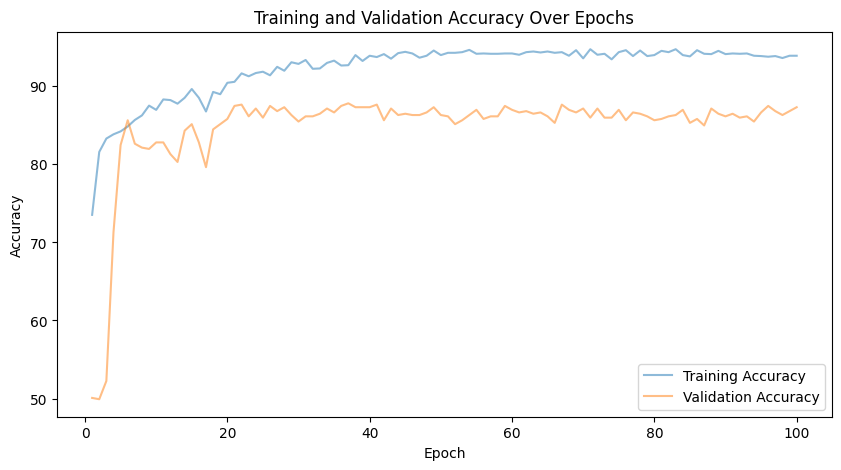

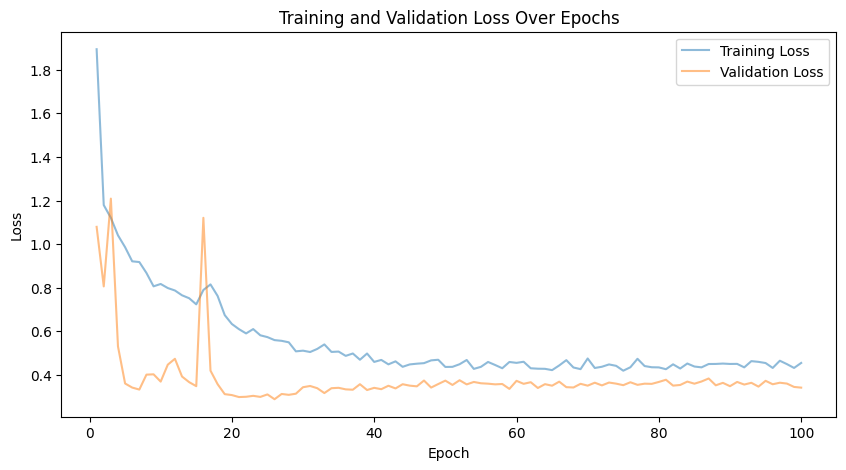

In [60]:
plot_metric('Accuracy', train_accuracies, val_accuracy, epochs=num_epochs)
plot_metric('Loss', train_losses, val_losses, epochs=num_epochs)

In [64]:
# custom_train_transform = transforms.Compose([
#     transforms.ToPILImage(),
#     #transforms.RandomHorizontalFlip(),
#     #transforms.RandomVerticalFlip(),
#     #transforms.RandomRotation(15),
#     #transforms.RandomResizedCrop(224, scale=(0.9, 1.1)),
#     transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
#     ToTensorAndMove(device),
# ])

# custom_val_transform = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
#     ToTensorAndMove(device),
# ])

In [65]:
# google_net_dataset = Data(device, mode='train',
#                                train_transform=custom_train_transform, val_transform=custom_val_transform)

# google_net_dataset.normalize()
# google_net_dataset.train_val_split()

# google_net_train_dataloader = DataLoader(google_net_dataset, batch_size=batch_size, shuffle=True)
# google_net_test_dataloader = DataLoader(google_net_dataset, batch_size=batch_size, shuffle=False)

In [66]:
# google_net_model = GoogLeNet().to(device)
# optimizer = optim.Adam(google_net_model.parameters(), lr=learning_rate)
# train_accuracies, train_losses, val_accuracy, val_losses = train_model(google_net_model, optimizer, criterion,
#                                                                        google_net_train_dataloader, google_net_test_dataloader,
#                                                                        google_net_dataset, num_epochs=num_epochs, device=device)